In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.naive_bayes
import sklearn.tree
import lime.lime_tabular_mod
import lime.lime_tabular_multiregressor
import matplotlib.pyplot as plt
import doc.mod.utils.DatasetRepository as dr
import doc.mod.utils.ResultsProcessing as rp
from tqdm import tqdm

repo = dr.DatasetRepository("../data")


pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})





# Dataset: Mushrooms

In [2]:
dataset = repo.get_mushrooms_dataset()
dataset.train_data

,cap-shape_bell,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_knobbed,cap-shape_sunken,cap-surface_fibrous,cap-surface_grooves,cap-surface_scaly,cap-surface_smooth,cap-color_brown,cap-color_buff,cap-color_cinnamon,cap-color_gray,cap-color_green,cap-color_pink,cap-color_purple,cap-color_red,cap-color_white,cap-color_yellow,bruises_bruises,bruises_no,odor_almond,odor_anise,odor_creosote,odor_fishy,odor_foul,odor_musty,odor_none,odor_pungent,odor_spicy,gill-attachment_attached,gill-attachment_free,gill-spacing_close,gill-spacing_crowded,gill-size_broad,gill-size_narrow,gill-color_black,gill-color_brown,gill-color_buff,gill-color_chocolate,gill-color_gray,gill-color_green,gill-color_orange,gill-color_pink,gill-color_purple,gill-color_red,gill-color_white,gill-color_yellow,stalk-shape_enlarging,stalk-shape_tapering,stalk-root_bulbous,stalk-root_club,stalk-root_equal,stalk-root_rooted,stalk-root_unknown,stalk-surface-above-ring_fibrous,stalk-surface-above-ring_scaly,stalk-surface-above-ring_silky,stalk-surface-above-ring_smooth,stalk-surface-below-ring_fibrous,stalk-surface-below-ring_scaly,stalk-surface-below-ring_silky,stalk-surface-below-ring_smooth,stalk-color-above-ring_brown,stalk-color-above-ring_buff,stalk-color-above-ring_cinnamon,stalk-color-above-ring_gray,stalk-color-above-ring_orange,stalk-color-above-ring_pink,stalk-color-above-ring_red,stalk-color-above-ring_white,stalk-color-above-ring_yellow,stalk-color-below-ring_brown,stalk-color-below-ring_buff,stalk-color-below-ring_cinnamon,stalk-color-below-ring_gray,stalk-color-below-ring_orange,stalk-color-below-ring_pink,stalk-color-below-ring_red,stalk-color-below-ring_white,stalk-color-below-ring_yellow,veil-type_partial,veil-color_brown,veil-color_orange,veil-color_white,veil-color_yellow,ring-number_none,ring-number_one,ring-number_two,ring-type_evanescent,ring-type_flaring,ring-type_large,ring-type_none,ring-type_pendant,spore-print-color_black,spore-print-color_brown,spore-print-color_buff,spore-print-color_chocolate,spore-print-color_green,spore-print-color_orange,spore-print-color_purple,spore-print-color_white,spore-print-color_yellow,population_abundant,population_clustered,population_numerous,population_scattered,population_several,population_solitary,habitat_grasses,habitat_leaves,habitat_meadows,habitat_paths,habitat_urban,habitat_waste,habitat_woods
445,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4293,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2774,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4668,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2737,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..





## Train different classifiers on selected dataset (with their default settings)

In [3]:
models = [
    ("Random Forest", sklearn.ensemble.RandomForestClassifier(n_jobs=-1)),
    ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
    ("DecisionTree", sklearn.tree.DecisionTreeClassifier()),
    ("Neural Network", sklearn.neural_network.MLPClassifier()),
    # ("SVM", sklearn.svm.LinearSVC()), do not provide predict_proba
    ("Naive Bayes", sklearn.naive_bayes.GaussianNB()),
    ("kNN", sklearn.neighbors.KNeighborsClassifier())
]
precision_for_classifier = {}
recall_for_classifier = {}
f1_for_classifier = {}
for (classifier_name, model) in models:
    x = dataset.train_data.to_numpy()
    y = dataset.train_labels.to_numpy()
    model.fit(x, y)

    x = dataset.test_data.to_numpy()
    y_true = dataset.test_labels.to_numpy()
    y_predicted = model.predict(x)

    precision_for_classifier[classifier_name] = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_predicted, average="macro")
    recall_for_classifier[classifier_name] = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_predicted, average="macro")
    f1_for_classifier[classifier_name] = sklearn.metrics.f1_score(y_true=y_true, y_pred=y_predicted, average="macro")
    
test_data_subset = dataset.test_data.to_numpy()

labels_count = 2
bins_count = 30
test_instances_count = test_data_subset.shape[0]


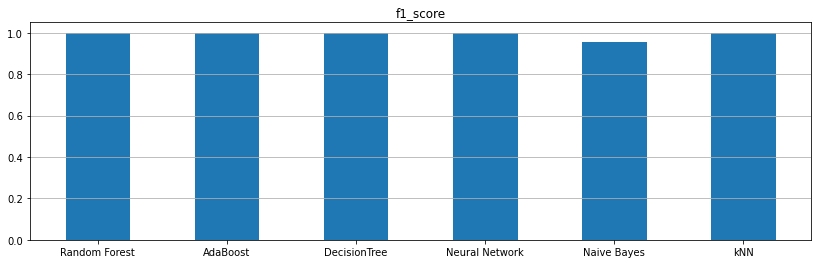

In [4]:
plt.figure(figsize=(14,4))
plt.bar(f1_for_classifier.keys(), f1_for_classifier.values(), width=0.5)
plt.title("f1_score")
plt.grid(axis="y")
plt.show()





## Use original LIME to explain classifiers' predictions

In [ ]:
scores_for_surrogate_model_default = \
    np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
losses_for_surrogate_model_default = \
    np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
fidelity_loss_on_explanation_default = \
    np.empty(shape=(len(models), test_instances_count,), dtype="float32")
fidelity_loss_on_generated_data_default = \
    np.empty(shape=(len(models), test_instances_count,), dtype="float32")
fidelity_loss_distribution_quantiles_default = \
    np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

for model_idx, (classifier_name, model) in enumerate(models):

    explainer_default = lime.lime_tabular_mod.LimeTabularExplainerMod(
        dataset.train_data.to_numpy(),
        feature_names = dataset.train_data.columns.to_list(),
        class_names = model.classes_,
        discretize_continuous=False,
        sample_around_instance=True,
        categorical_features=dataset.categorical_features
    )

    for instance_idx, test_instance in enumerate(tqdm(
                test_data_subset,
                desc=f"{classifier_name}",
                bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
    )):

        explanation = explainer_default.explain_instance(
            test_instance.reshape(-1),
            model.predict_proba,
            num_features = 4,
            top_labels = labels_count,
            distance_metric="minkowski",
            minkowski_norm=100.
        )
        scores_for_surrogate_model_default[model_idx, instance_idx, :] = \
            explanation.get_scores_for_surrogate_model()
        losses_for_surrogate_model_default[model_idx, instance_idx, :] = \
            explanation.get_losses_for_surrogate_model()
        fidelity_loss_on_explanation_default[model_idx, instance_idx] = \
            explanation.get_fidelity_loss_on_explanation()
        fidelity_loss_on_generated_data_default[model_idx, instance_idx] = \
            explanation.get_fidelity_loss_on_generated_data()
        fidelity_loss_distribution_quantiles_default[model_idx, instance_idx, :] = \
            explanation.get_fidelity_loss_distribution(bins=bins_count)

postprocessor_default = rp.ResultsProcessing(
    models,
    labels_count,
    scores_for_surrogate_model_default,
    losses_for_surrogate_model_default,
    fidelity_loss_on_explanation_default,
    fidelity_loss_on_generated_data_default,
    fidelity_loss_distribution_quantiles_default
)

AdaBoost             36%|███▌      | 578/1625 [18:53<32:40,  1.87s/it]  

In [ ]:
postprocessor_default.plot_scores_for_surrogate_model()

In [ ]:
postprocessor_default.plot_losses_for_surrogate_model()

In [ ]:
postprocessor_default.plot_fidelity_loss_on_explanation()

In [ ]:
postprocessor_default.plot_fidelity_losses_on_generated_data()

In [ ]:
postprocessor_default.plot_fidelity_loss_distribution(domain_unit="Bins")





## Use modified LIME to explain classifiers' predictions





### Use multiple Regression Trees as local surrogate

In [ ]:
scores_for_surrogate_model_multiregression = \
    np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
losses_for_surrogate_model_multiregression = \
    np.empty(shape=(len(models), test_instances_count, labels_count), dtype="float32")
fidelity_loss_on_explanation_multiregression = \
    np.empty(shape=(len(models), test_instances_count,), dtype="float32")
fidelity_loss_on_generated_data_multiregression = \
    np.empty(shape=(len(models), test_instances_count,), dtype="float32")
fidelity_loss_distribution_quantiles_multiregression = \
    np.empty(shape=(len(models), test_instances_count, bins_count), dtype="float32")

for model_idx, (classifier_name, model) in enumerate(models):

    explainer_multiregression = lime.lime_tabular_multiregressor.LTEMultiRegressionTree(
        dataset.train_data.to_numpy(),
        feature_names = dataset.train_data.columns.to_list(),
        class_names = model.classes_,
        discretize_continuous=False,
        sample_around_instance=True,
        categorical_features=dataset.categorical_features
    )

    for instance_idx, test_instance in enumerate(tqdm(
                test_data_subset,
                desc=f"{classifier_name}",
                bar_format="{desc:<20}{percentage:3.0f}%|{bar}{r_bar}"
    )):

        explanation = explainer_multiregression.explain_instance(
            test_instance.reshape(-1),
            model.predict_proba,
            num_features = 4,
            top_labels = labels_count,
            distance_metric="minkowski",
            minkowski_norm=100.
        )
        scores_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
            explanation.get_scores_for_surrogate_model()
        losses_for_surrogate_model_multiregression[model_idx, instance_idx, :] = \
            explanation.get_losses_for_surrogate_model()
        fidelity_loss_on_explanation_multiregression[model_idx, instance_idx] = \
            explanation.get_fidelity_loss_on_explanation()
        fidelity_loss_on_generated_data_multiregression[model_idx, instance_idx] = \
            explanation.get_fidelity_loss_on_generated_data()
        fidelity_loss_distribution_quantiles_multiregression[model_idx, instance_idx, :] = \
            explanation.get_fidelity_loss_distribution(bins=bins_count)


postprocessor_multiregression = rp.ResultsProcessing(
    models,
    labels_count,
    scores_for_surrogate_model_multiregression,
    losses_for_surrogate_model_multiregression,
    fidelity_loss_on_explanation_multiregression,
    fidelity_loss_on_generated_data_multiregression,
    fidelity_loss_distribution_quantiles_multiregression
)

In [ ]:
postprocessor_multiregression.plot_scores_for_surrogate_model()

In [ ]:
postprocessor_multiregression.plot_losses_for_surrogate_model()

In [ ]:
postprocessor_multiregression.plot_fidelity_loss_on_explanation()

In [ ]:
postprocessor_multiregression.plot_fidelity_losses_on_generated_data()

In [ ]:
postprocessor_multiregression.plot_fidelity_loss_distribution(domain_unit="Bins")

In [ ]:
with open(f"saved_results/Mushrooms/multiregression_results.npy", "wb") as file:
    np.save(file, postprocessor_multiregression.scores_for_surrogate_model)
    np.save(file, postprocessor_multiregression.losses_for_surrogate_model)
    np.save(file, postprocessor_multiregression.fidelity_loss_on_explanation)
    np.save(file, postprocessor_multiregression.fidelity_loss_on_generated_data)
    np.save(file, postprocessor_multiregression.fidelity_loss_distribution)

with open(f"saved_results/Mushrooms/default_results.npy", "wb") as file:
    np.save(file, postprocessor_default.scores_for_surrogate_model)
    np.save(file, postprocessor_default.losses_for_surrogate_model)
    np.save(file, postprocessor_default.fidelity_loss_on_explanation)
    np.save(file, postprocessor_default.fidelity_loss_on_generated_data)
    np.save(file, postprocessor_default.fidelity_loss_distribution)
